In [1]:
#import library
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score, brier_score_loss
from skmultilearn.model_selection import iterative_train_test_split

#### Reading File

In [2]:
df = pd.read_csv("../data/cleaned_data.csv")

In [3]:
df.head()

,Incident Hour,Precinct Of Incident Occurrence,year,in_news,month,Last Reported Active Year,Rank Changed,Command Changed,Total Complaints_z_score,Total Substantiated Complaints_z_score,...,Current Rank_Chiefs and other ranks,Current Rank_Deputy Inspector,Current Rank_Detective,Current Rank_Inspector,Current Rank_Lieutenant,Current Rank_Police Officer,Current Rank_Sergeant,CCRB Complaint Disposition,PenaltyRecoded,PenaltyCount
0,7.0,63.0,2019.0,0.0,5.0,2022.0,0.0,0.0,2.078182,-0.113459,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Unsubstantiated,Not Applicable,Not Applicable
1,5.0,73.0,2014.0,0.0,8.0,2015.0,0.0,0.0,-0.854419,-0.113459,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated,Other,1
2,5.0,73.0,2014.0,0.0,8.0,2015.0,0.0,0.0,-0.854419,-0.113459,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated,Other,1
3,2.0,42.0,2019.0,0.0,2.0,2025.0,0.0,0.0,-0.854419,-0.721040,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable
4,2.0,42.0,2019.0,0.0,2.0,2025.0,0.0,0.0,-0.854419,-0.721040,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable


#### Setting up X and Y, Splitting Datasets, and SMOTE

In [4]:
#setting up y / complaint
complaint_label_encoder = LabelEncoder()
y = complaint_label_encoder.fit_transform(df["CCRB Complaint Disposition"])

In [5]:
# View the class-to-integer mapping
class_map = dict(zip(complaint_label_encoder.classes_, range(len(complaint_label_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(complaint_label_encoder.classes_, range(len(complaint_label_encoder.classes_)))))

Class to Integer Mapping: {'Exonerated': 0, 'Substantiated': 1, 'Unfounded': 2, 'Unsubstantiated': 3}


In [6]:
#setting up x and extracting ys for now
ys = df[["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"]]
x = df.drop(columns = ["CCRB Complaint Disposition", "PenaltyRecoded", "PenaltyCount"])

In [7]:
#training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 3)

In [8]:
#SMOTE for class imbalance
smote = SMOTE(random_state = 10)

In [9]:
#applying SMOTE to training
x_res, y_res = smote.fit_resample(x_train, y_train)

In [10]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

3    3196
1    2381
0     634
2     394
Name: count, dtype: int64
0    3196
1    3196
3    3196
2    3196
Name: count, dtype: int64


### Complaint Models

In [11]:
def model_perf(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
                xticklabels=class_map, yticklabels=class_map)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()



C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.23      0.42      0.30       159
           1       0.62      0.55      0.58       595
           2       0.14      0.49      0.22        99
           3       0.68      0.42      0.52       799

    accuracy                           0.47      1652
   macro avg       0.42      0.47      0.40      1652
weighted avg       0.59      0.47      0.50      1652

Balanced Accuracy: 0.4701446078473967
F1-Weighted: 0.5036353038272917
F1-Macro: 0.4049580556397455


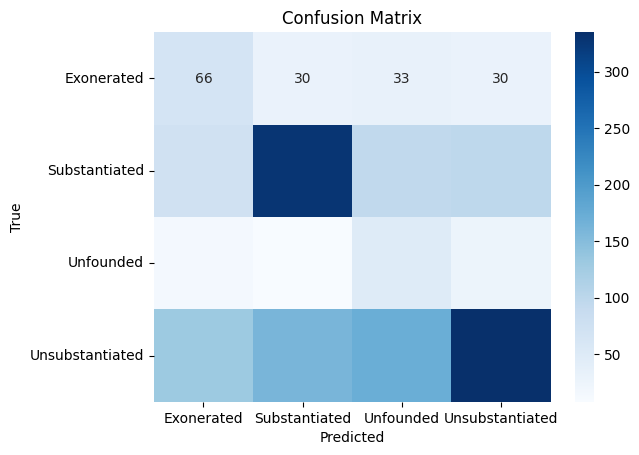

In [12]:
#logistic regression
model_perf("Logistic", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.90      0.45      0.60       159
           1       0.87      0.89      0.88       595
           2       0.92      0.61      0.73        99
           3       0.82      0.93      0.87       799

    accuracy                           0.85      1652
   macro avg       0.88      0.72      0.77      1652
weighted avg       0.85      0.85      0.84      1652

Balanced Accuracy: 0.7192640897094578
F1-Weighted: 0.8413582926615647
F1-Macro: 0.7721450795859889


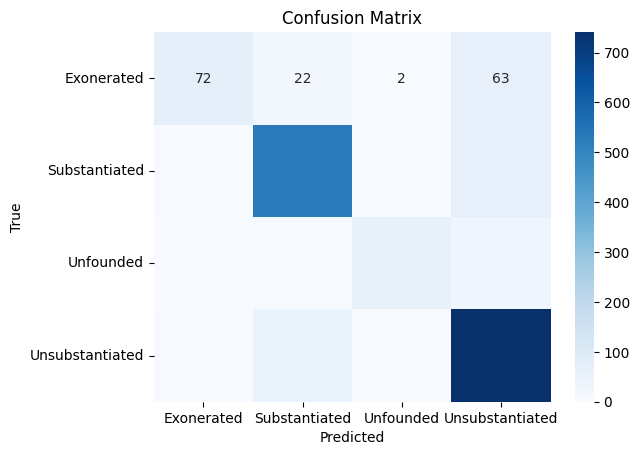

In [13]:
#random forest
model_perf("RF", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.08      0.40      0.14       159
           1       1.00      0.00      0.00       595
           2       0.09      0.16      0.11        99
           3       0.51      0.45      0.48       799

    accuracy                           0.27      1652
   macro avg       0.42      0.25      0.18      1652
weighted avg       0.62      0.27      0.25      1652

Balanced Accuracy: 0.25346028658778086
F1-Weighted: 0.2533795165095074
F1-Macro: 0.18373291571939065


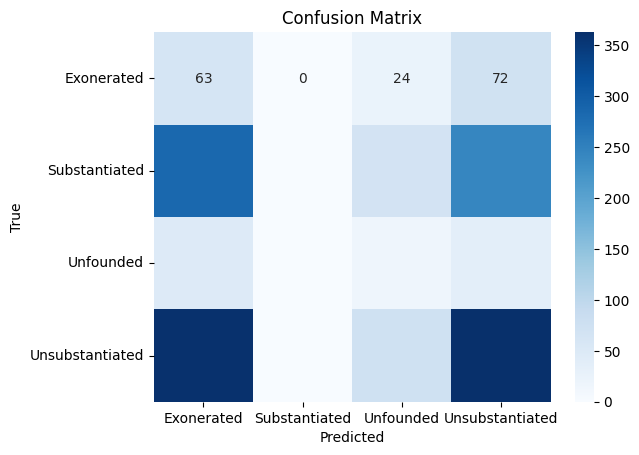

In [14]:
#svm
model_perf("SVM", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.83      0.45      0.58       159
           1       0.89      0.90      0.89       595
           2       0.89      0.72      0.79        99
           3       0.83      0.93      0.88       799

    accuracy                           0.86      1652
   macro avg       0.86      0.75      0.79      1652
weighted avg       0.86      0.86      0.85      1652

Balanced Accuracy: 0.746730044644891
F1-Weighted: 0.8500537686132581
F1-Macro: 0.7862863283604121


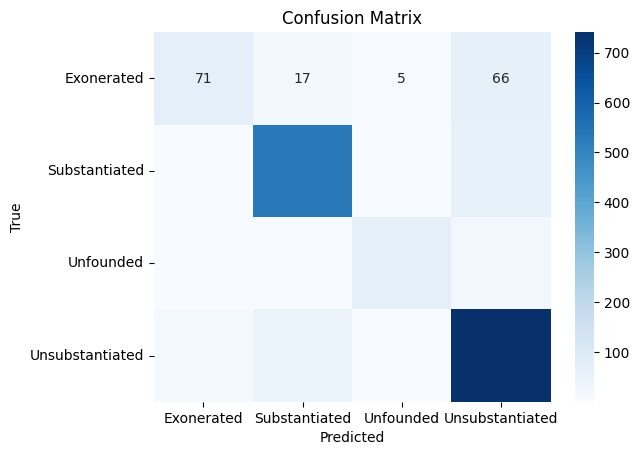

In [15]:
#XGBoost
model_perf("XGB", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.32      0.64      0.42       159
           1       0.75      0.73      0.74       595
           2       0.35      0.86      0.50        99
           3       0.88      0.57      0.69       799

    accuracy                           0.65      1652
   macro avg       0.58      0.70      0.59      1652
weighted avg       0.75      0.65      0.67      1652

Balanced Accuracy: 0.69785700297661
F1-Weighted: 0.6716225710498113
F1-Macro: 0.5882436996693209


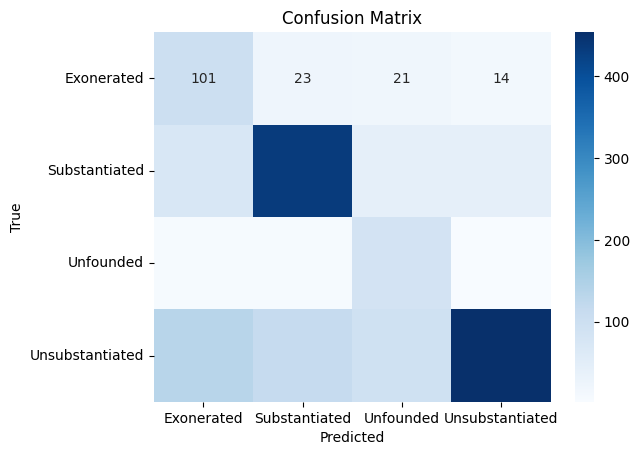

In [16]:
#KNN
model_perf("KNN", x_res, y_res, x_valid, y_valid)

#### Hyperparameter Tuning

In [17]:
#parameter to tune for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [18]:
#initiates rf
rf_tune = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")

In [19]:
#randomized search + cross validation
rf_gs = RandomizedSearchCV(rf_tune, rf_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [20]:
rf_gs.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300]},
                   scoring='f1_weighted')

In [21]:
#performance and best params
print("Best Parameters:", rf_gs.best_params_)
print("Best F1 Score (Weighted):", rf_gs.best_score_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best F1 Score (Weighted): 0.9007473489126788


In [22]:
#parameters to tune for XG Boost
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [23]:
#initiates xg boost
xgb_tuned = XGBClassifier(objective='multi:softmax', 
                            num_class=4,
                          random_state=2)

In [24]:
#randomized search + cross validation
xgb_sv = RandomizedSearchCV(xgb_tuned, xgb_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [25]:
#fixes columns
x_res.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [26]:
xgb_sv.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=4, num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='f1_weighted')

In [27]:
#performance and best params
print("Best Parameters:", xgb_sv.best_params_)
print("Best F1 Score (Weighted):", xgb_sv.best_score_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.7}
Best F1 Score (Weighted): 0.8969068014890549


#### Final Model Assessment

In [28]:
if xgb_sv.best_score_ > rf_gs.best_score_:
    complaint_mod = XGBClassifier(**xgb_sv.best_params_)
else:
    complaint_mod = RandomForestClassifier(**rf_gs.best_params_)

In [29]:
complaint_mod

RandomForestClassifier(n_estimators=200)

In [30]:
complaint_mod.fit(x_res, y_res)

RandomForestClassifier(n_estimators=200)

In [31]:
#compute predicted
x_test.columns = x_test.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred = complaint_mod.predict(x_test)

In [32]:
#performance metrics
complaint_conf_matrix = confusion_matrix(y_test, complaint_pred)
complaint_class_report = classification_report(y_test, complaint_pred, zero_division = 0)
complaint_fl_weighted = f1_score(y_test, complaint_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.87      0.52      0.65       199
           1       0.89      0.91      0.90       744
           2       0.88      0.56      0.69       123
           3       0.85      0.93      0.89       999

    accuracy                           0.86      2065
   macro avg       0.87      0.73      0.78      2065
weighted avg       0.87      0.86      0.86      2065

F1-Weighted: 0.8576380270971883


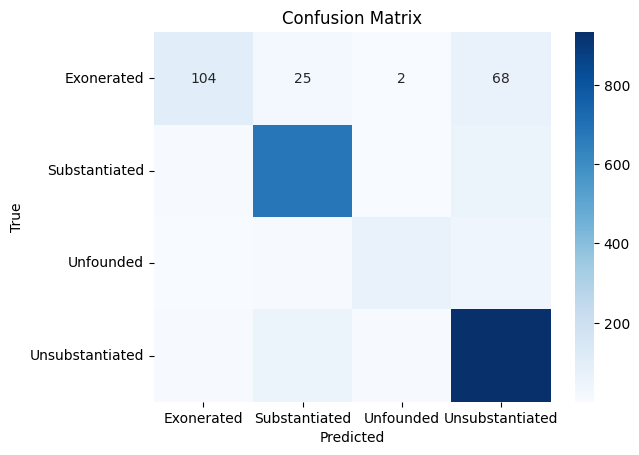

In [33]:
#printing report
print(complaint_class_report)
print(f'F1-Weighted: {complaint_fl_weighted}')

#confusion matrix plot
sns.heatmap(complaint_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
           xticklabels=class_map, yticklabels=class_map)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [34]:
#most impt features
pd.DataFrame({
    'Feature': x_res.columns,
    'Importance': complaint_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
9,Total Substantiated Complaints_z_score,0.073198
1,Precinct Of Incident Occurrence,0.050704
0,Incident Hour,0.043409
10,Officer Days On Force At Incident_zscore,0.041767
4,month,0.040403
8,Total Complaints_z_score,0.040097
2,year,0.035562
23,FADO Type_Abuse of Authority,0.022918
59,Reason for Police Contact_Suspect of Crime,0.021415
61,Outcome Of Police Encounter_Arrest,0.019274


In [35]:
#Complaint Mod
explainer = shap.Explainer(complaint_mod, x_train)
shap_values = explainer(x_test)

100%|===================| 8257/8260 [25:45<00:00]        

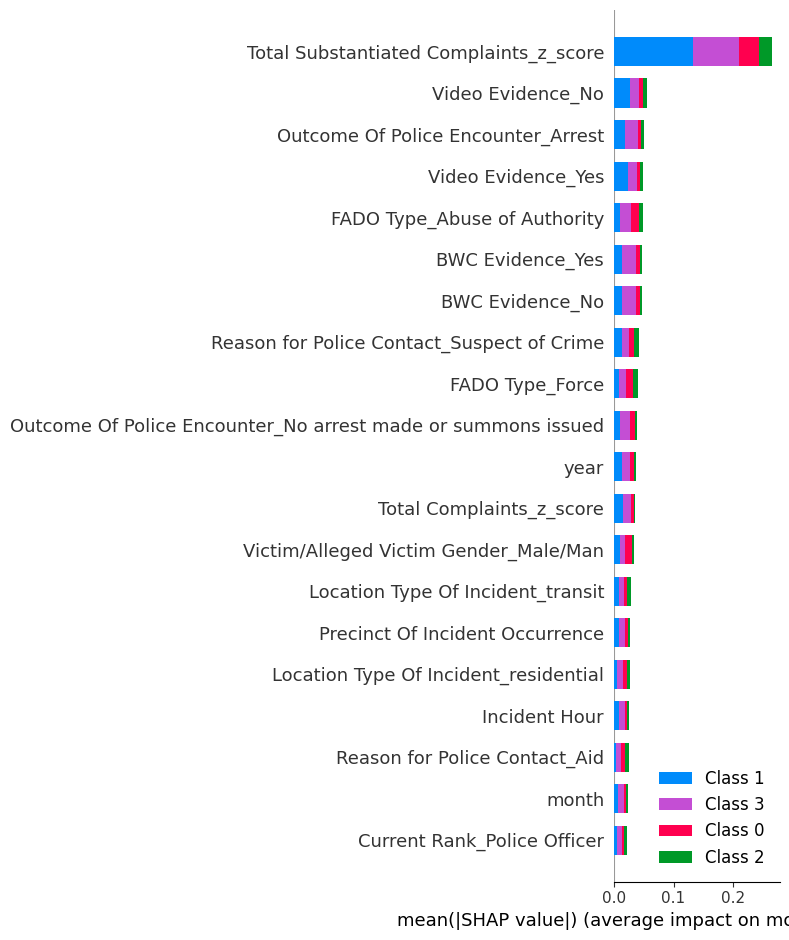

In [36]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test, show=False)
plt.tight_layout()
plt.show()

#### Turning Complaints into Binary

In [37]:
#dichotomizing y
bin_y = np.where(ys['CCRB Complaint Disposition'] == "Substantiated",1, 0)

In [38]:
bin_map = {'Substantiated': 1, "Not Substantiated": 0}

In [39]:
#train test split
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, bin_y, test_size = 0.2, stratify = bin_y, random_state = 3)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2, y_train2, test_size = 0.2, stratify = y_train2, random_state = 3)

In [40]:
#SMOTE for class imbalance
smote2 = SMOTE(random_state = 10)

#applying SMOTE to training
x_res2, y_res2 = smote2.fit_resample(x_train2, y_train2)

In [41]:
#check class dist
print(pd.Series(y_train2).value_counts())
print(pd.Series(y_res2).value_counts())

0    4224
1    2381
Name: count, dtype: int64
0    4224
1    4224
Name: count, dtype: int64


In [42]:
def model_perf_bin(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #fix col names
    x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
               xticklabels=bin_map, yticklabels=bin_map)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

In [43]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1057
           1       0.61      0.69      0.65       595

    accuracy                           0.73      1652
   macro avg       0.71      0.72      0.71      1652
weighted avg       0.74      0.73      0.73      1652

Balanced Accuracy: 0.7214424842784797
F1-Weighted: 0.7331564428639301
F1-Macro: 0.7146040048837021


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


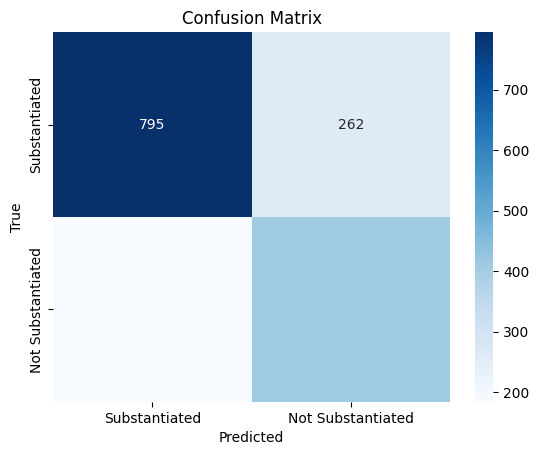

RF
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1057
           1       0.92      0.85      0.88       595

    accuracy                           0.92      1652
   macro avg       0.92      0.90      0.91      1652
weighted avg       0.92      0.92      0.92      1652

Balanced Accuracy: 0.9047637598085592
F1-Weighted: 0.918784902261969
F1-Macro: 0.9111928115472465


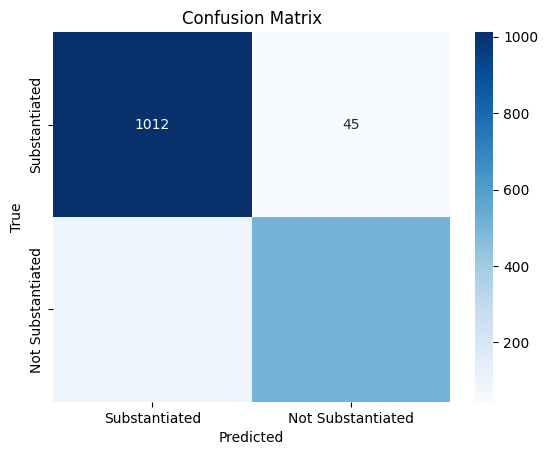

SVM
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1057
           1       1.00      0.00      0.00       595

    accuracy                           0.64      1652
   macro avg       0.82      0.50      0.39      1652
weighted avg       0.77      0.64      0.50      1652

Balanced Accuracy: 0.5008403361344538
F1-Weighted: 0.5006922616406231
F1-Macro: 0.39200281542137144


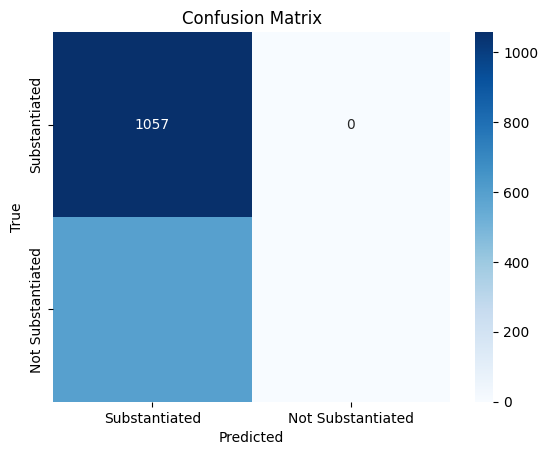

XGB
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1057
           1       0.90      0.88      0.89       595

    accuracy                           0.92      1652
   macro avg       0.91      0.91      0.91      1652
weighted avg       0.92      0.92      0.92      1652

Balanced Accuracy: 0.9102732483721965
F1-Weighted: 0.9192929458348813
F1-Macro: 0.9122357327542991


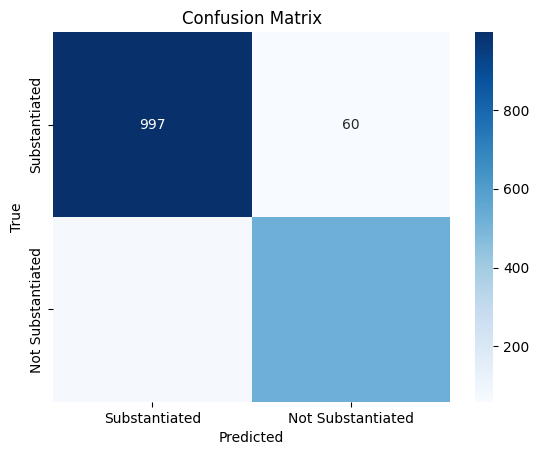

KNN
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1057
           1       0.67      0.82      0.74       595

    accuracy                           0.79      1652
   macro avg       0.78      0.79      0.78      1652
weighted avg       0.81      0.79      0.79      1652

Balanced Accuracy: 0.7945072068562524
F1-Weighted: 0.7922070435036006
F1-Macro: 0.7797934852561765


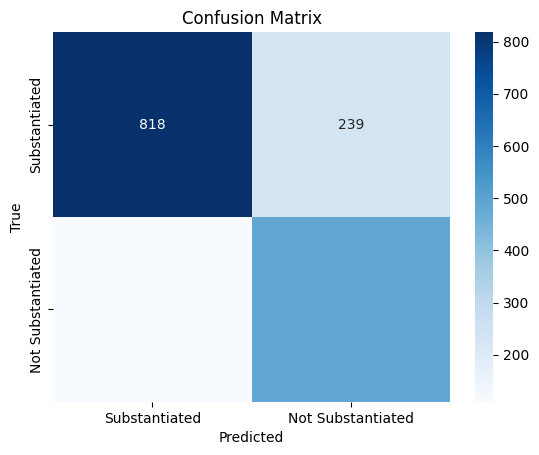

In [44]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_bin(model, x_res2, y_res2, x_valid2, y_valid2)

In [45]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [46]:
top_bin_models = ["RF", "XGB"]

In [47]:
score_storage = {}
param_storage = {}

In [48]:
#hyperparameter tuning
for top_mod in top_bin_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res2, y_res2)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_

Best Parameters for RF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best F1 Score (Weighted) for RF: 0.9255188189149026
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}
Best F1 Score (Weighted) for XGB: 0.9273160603279862


In [49]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    complaint_mod_bin = XGBClassifier(**param_storage["XGB"])
else:
    complaint_mod_bin = XGBClassifier(**param_storage["RF"])

In [50]:
#fit mod
complaint_mod_bin.fit(x_res2, y_res2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
#compute predicted
x_test2.columns = x_test2.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred_bin = complaint_mod_bin.predict(x_test2)

In [52]:
#performance metrics
complaint_bin_conf_matrix = confusion_matrix(y_test2, complaint_pred_bin)
complaint_bin_class_report = classification_report(y_test2, complaint_pred_bin, zero_division = 0)
complaint_bin_fl_weighted = f1_score(y_test2, complaint_pred_bin, average = 'weighted')

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1321
           1       0.91      0.90      0.90       744

    accuracy                           0.93      2065
   macro avg       0.93      0.92      0.93      2065
weighted avg       0.93      0.93      0.93      2065

F1-Weighted: 0.9311735722712919


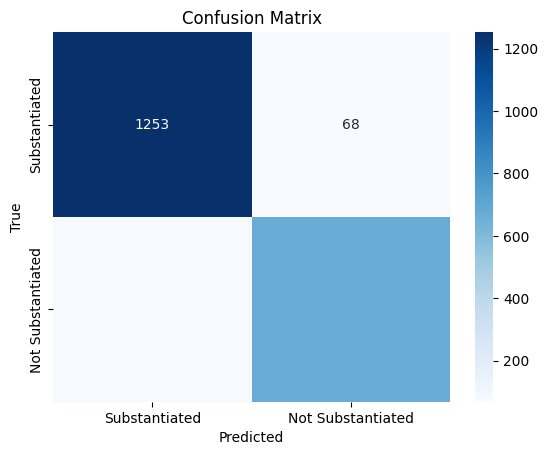

In [53]:
#printing report
print(complaint_bin_class_report)
print(f'F1-Weighted: {complaint_bin_fl_weighted}')

#confusion matrix plot
sns.heatmap(complaint_bin_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
            xticklabels=bin_map, yticklabels=bin_map)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [54]:
pd.DataFrame({
    'Feature': x_res2.columns,
    'Importance': complaint_mod_bin.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
9,Total Substantiated Complaints_z_score,0.112367
68,Video Evidence_Yes,0.076325
19,Officer Rank At Incident_Lieutenant,0.032366
11,news_hits,0.031565
14,recent_prev_penalty,0.030462
65,BWC Evidence_No,0.029918
79,Current Rank_Captain,0.027071
25,FADO Type_Force,0.024520
67,Video Evidence_No,0.019181
84,Current Rank_Lieutenant,0.017996


In [55]:
#Bin Mod
explainer = shap.Explainer(complaint_mod_bin, x_train2)
shap_values = explainer(x_test2)

 96%|=================== | 1978/2065 [00:18<00:00]       

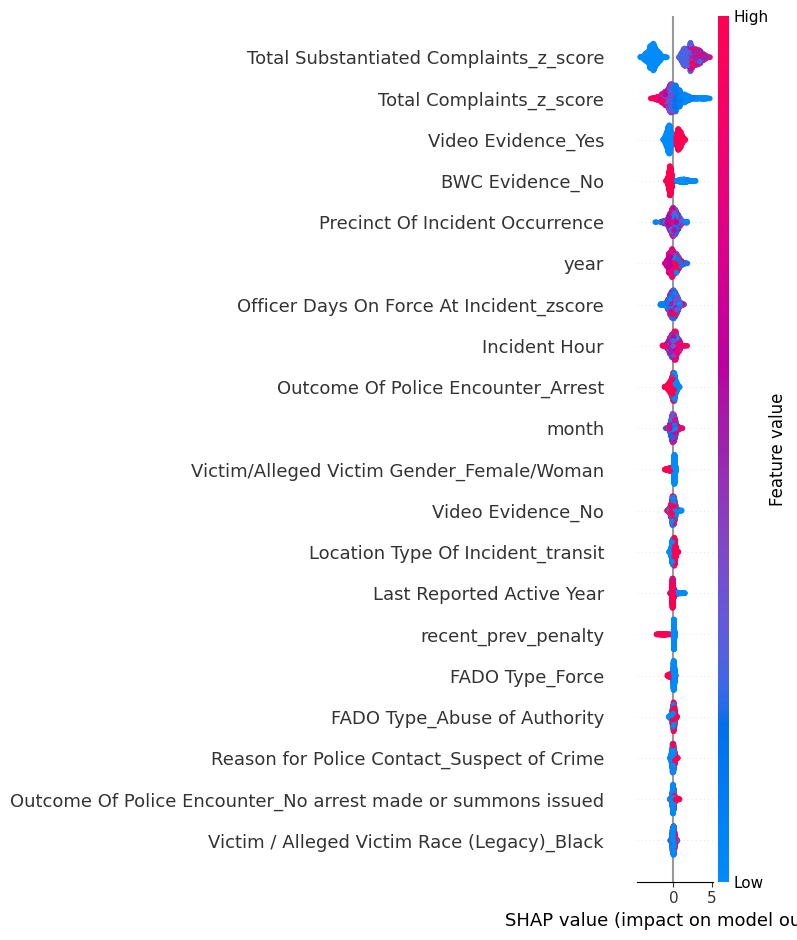

In [56]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test2, show=False)
plt.tight_layout()
plt.show()

### Penalty Type Models

In [57]:
penalty_df = df.copy().query('PenaltyRecoded != "Not Applicable"')

In [58]:
penalty_df['PenaltyRecoded'].value_counts()

PenaltyRecoded
Formalized Training     671
Command Discipline A    558
Instructions            430
No Penalty              371
Vacation Loss           305
Command Discipline B    146
Other                    58
Name: count, dtype: int64

In [59]:
penalty_df.shape

(2539, 90)

In [60]:
#encoding penalty type
penalty_encoder = LabelEncoder()
y = penalty_encoder.fit_transform(penalty_df['PenaltyRecoded'])

In [61]:
# View the class-to-integer mapping
penalty_map = dict(zip(penalty_encoder.classes_, range(len(penalty_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(penalty_encoder.classes_, range(len(penalty_encoder.classes_)))))

Class to Integer Mapping: {'Command Discipline A': 0, 'Command Discipline B': 1, 'Formalized Training': 2, 'Instructions': 3, 'No Penalty': 4, 'Other': 5, 'Vacation Loss': 6}


In [62]:
x = penalty_df.drop(columns = ["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"])

In [63]:
#training, validation, and test sets
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x_train3, y_train3, test_size = 0.2, stratify = y_train3, random_state = 3)

In [64]:
#SMOTE for class imbalance
smote_penalty = SMOTE(random_state = 10)

#applying SMOTE to training
x_res3, y_res3 = smote_penalty.fit_resample(x_train3, y_train3)

In [65]:
#check class dist
print(pd.Series(y_train3).value_counts())
print(pd.Series(y_res3).value_counts())

2    429
0    357
3    275
4    237
6    195
1     94
5     37
Name: count, dtype: int64
6    429
1    429
4    429
3    429
2    429
0    429
5    429
Name: count, dtype: int64


In [66]:
def model_perf_type(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
               xticklabels=penalty_map, yticklabels=penalty_map)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

In [67]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.40      0.16      0.23        89
           1       0.28      0.65      0.39        23
           2       0.47      0.40      0.43       108
           3       0.45      0.39      0.42        69
           4       0.23      0.18      0.21        60
           5       0.22      0.89      0.35         9
           6       0.33      0.55      0.41        49

    accuracy                           0.36       407
   macro avg       0.34      0.46      0.35       407
weighted avg       0.38      0.36      0.34       407

Balanced Accuracy: 0.46031034431281675
F1-Weighted: 0.3440092884972876
F1-Macro: 0.34738177393770037


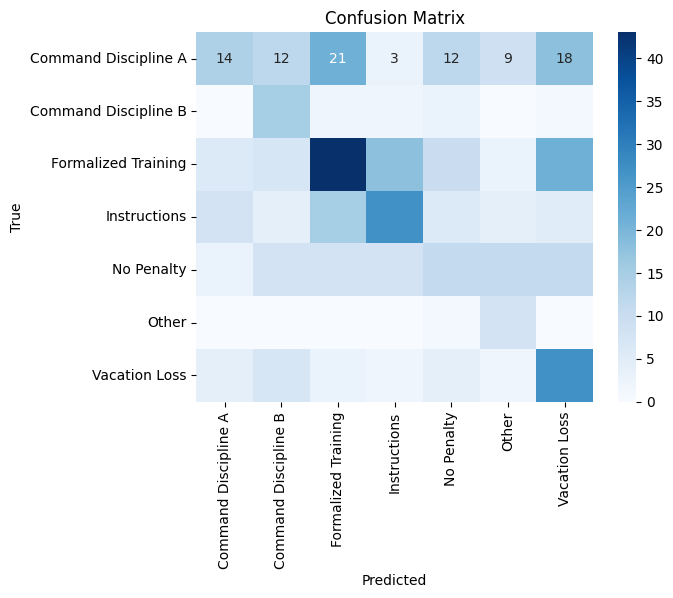

RF
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        89
           1       1.00      0.96      0.98        23
           2       0.89      0.93      0.91       108
           3       0.96      0.93      0.94        69
           4       0.95      0.95      0.95        60
           5       1.00      0.89      0.94         9
           6       0.91      0.86      0.88        49

    accuracy                           0.92       407
   macro avg       0.94      0.92      0.93       407
weighted avg       0.92      0.92      0.92       407

Balanced Accuracy: 0.9181948510827008
F1-Weighted: 0.9214979644814831
F1-Macro: 0.929929928918178


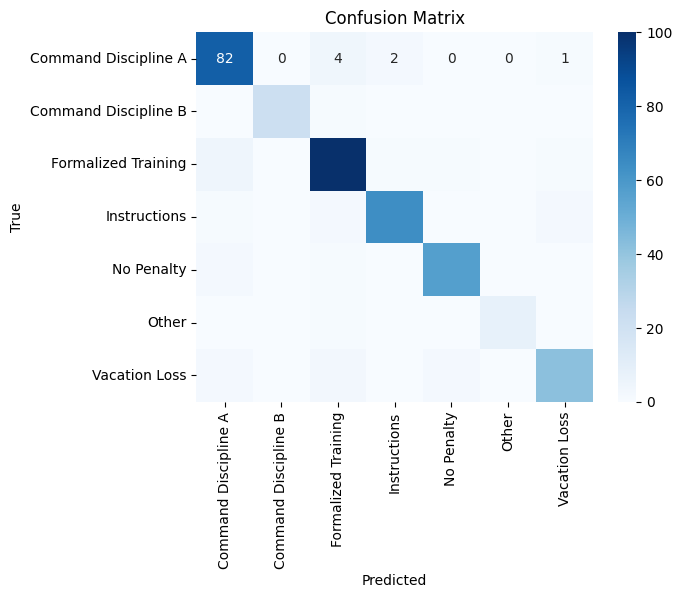

SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.06      0.22      0.09        23
           2       0.29      0.06      0.09       108
           3       0.00      0.00      0.00        69
           4       0.10      0.18      0.13        60
           5       0.03      0.56      0.05         9
           6       0.18      0.04      0.07        49

    accuracy                           0.07       407
   macro avg       0.09      0.15      0.06       407
weighted avg       0.12      0.07      0.06       407

Balanced Accuracy: 0.15037886790326896
F1-Weighted: 0.05825580196918268
F1-Macro: 0.062074372778518225


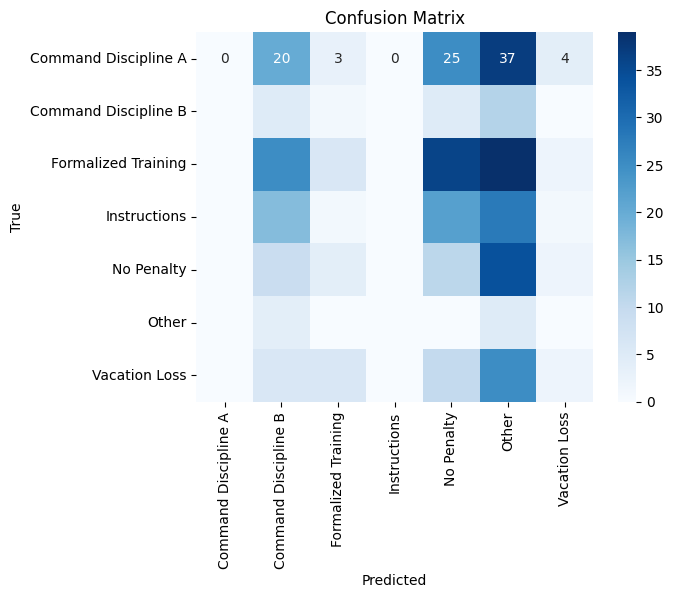

XGB
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        89
           1       0.92      0.96      0.94        23
           2       0.92      0.89      0.91       108
           3       0.91      0.88      0.90        69
           4       0.96      0.90      0.93        60
           5       1.00      0.89      0.94         9
           6       0.86      0.88      0.87        49

    accuracy                           0.90       407
   macro avg       0.92      0.90      0.91       407
weighted avg       0.90      0.90      0.90       407

Balanced Accuracy: 0.9024652604196587
F1-Weighted: 0.8997348505507624
F1-Macro: 0.9081132261830238


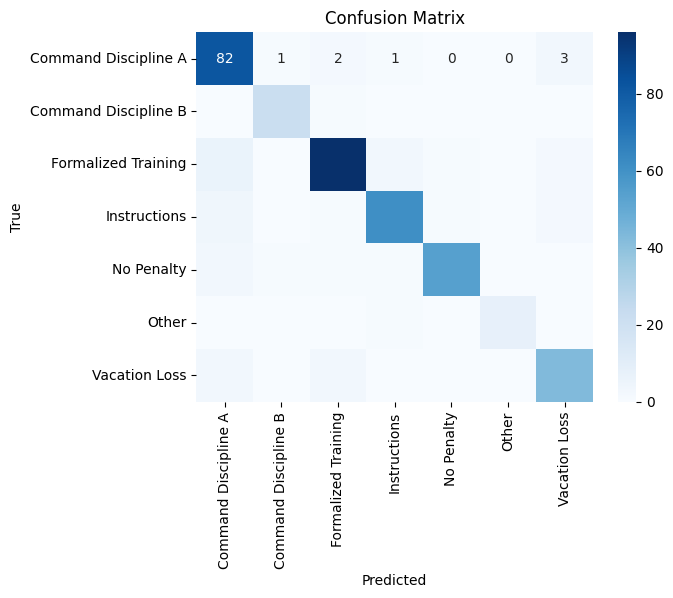

KNN
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        89
           1       0.50      0.96      0.66        23
           2       0.76      0.60      0.67       108
           3       0.77      0.70      0.73        69
           4       0.69      0.73      0.71        60
           5       0.62      0.89      0.73         9
           6       0.72      0.80      0.76        49

    accuracy                           0.71       407
   macro avg       0.68      0.77      0.71       407
weighted avg       0.72      0.71      0.71       407

Balanced Accuracy: 0.7653656589844939
F1-Weighted: 0.705249136934493
F1-Macro: 0.7084397071913172


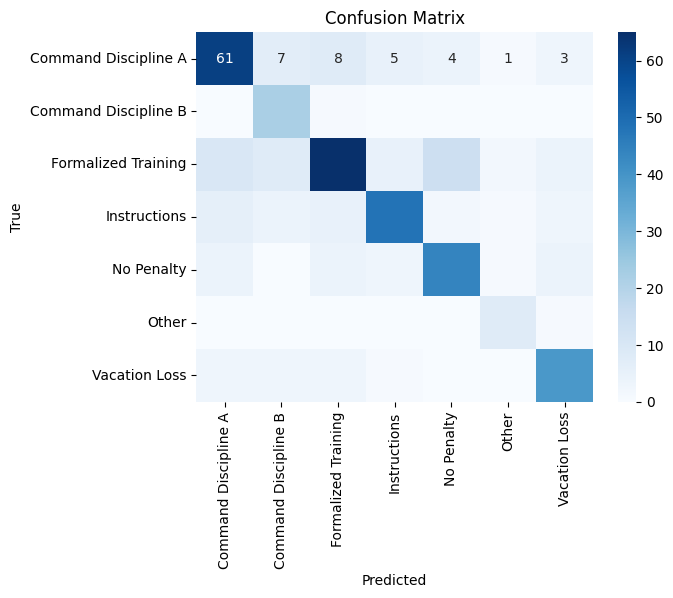

In [68]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_type(model, x_res3, y_res3, x_valid3, y_valid3)

In [69]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [70]:
top_pen_models = ["RF", "XGB"]

In [71]:
score_storage = {}
param_storage = {}

In [72]:
#hyperparameter tuning
for top_mod in top_pen_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res3, y_res3)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_



Best Parameters for RF: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best F1 Score (Weighted) for RF: 0.9182156770063441
Best Parameters for XGB: {'subsample': 0.7, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted) for XGB: 0.9079788138023147


In [73]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    penalty_mod = XGBClassifier(**param_storage["XGB"])
else:
    penalty_mod = XGBClassifier(**param_storage["RF"])

In [74]:
#fit mod
penalty_mod.fit(x_res3, y_res3)

C:\Users\helen\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features='log2',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, ...)

In [75]:
#compute predicted
x_test3.columns = x_test3.columns.str.replace(r'[\[\]<>]', '', regex=True)
penalty_pred = penalty_mod.predict(x_test3)

In [76]:
#performance metrics
pen_conf_matrix = confusion_matrix(y_test3, penalty_pred)
pen_class_report = classification_report(y_test3, penalty_pred, zero_division = 0)
pen_fl_weighted = f1_score(y_test3, penalty_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       112
           1       1.00      0.90      0.95        29
           2       0.88      0.92      0.90       134
           3       0.90      0.84      0.87        86
           4       0.92      0.93      0.93        74
           5       1.00      1.00      1.00        12
           6       0.94      0.84      0.89        61

    accuracy                           0.90       508
   macro avg       0.93      0.91      0.92       508
weighted avg       0.90      0.90      0.90       508

F1-Weighted: 0.8995103425110085


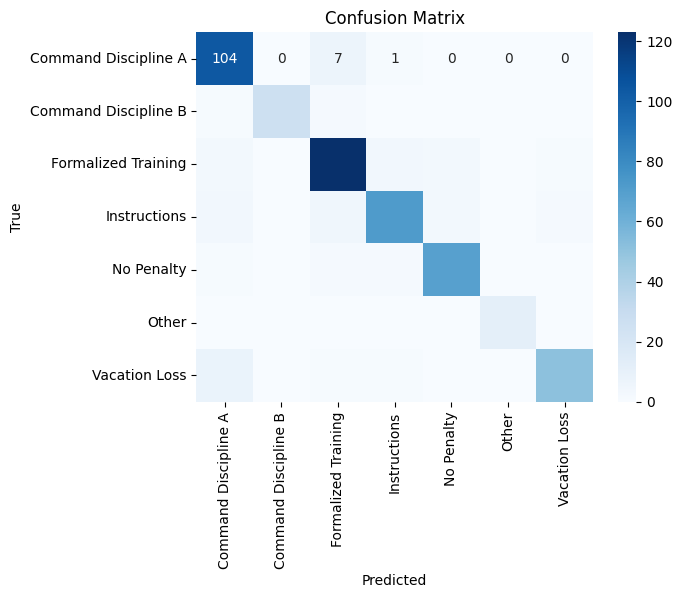

In [77]:
#printing report
print(pen_class_report)
print(f'F1-Weighted: {pen_fl_weighted}')

#confusion matrix plot
sns.heatmap(pen_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
           xticklabels=penalty_map, yticklabels=penalty_map)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [78]:
pd.DataFrame({
    'Feature': x_res3.columns,
    'Importance': penalty_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
16,Officer Rank At Incident_Deputy Inspector,0.181624
54,Reason for Police Contact_Aid,0.056704
84,Current Rank_Lieutenant,0.034212
68,Video Evidence_Yes,0.031286
39,Victim / Alleged Victim Race (Legacy)_Asian,0.028325
79,Current Rank_Captain,0.026227
5,Last Reported Active Year,0.026094
13,recent_prev_subs,0.025141
47,Borough Of Incident Occurrence_Outside NYC,0.024308
19,Officer Rank At Incident_Lieutenant,0.021230


In [79]:
#Penalty Mod
explainer = shap.Explainer(penalty_mod, x_train3)
shap_values = explainer(x_test3)

100%|===================| 3543/3556 [02:39<00:00]        

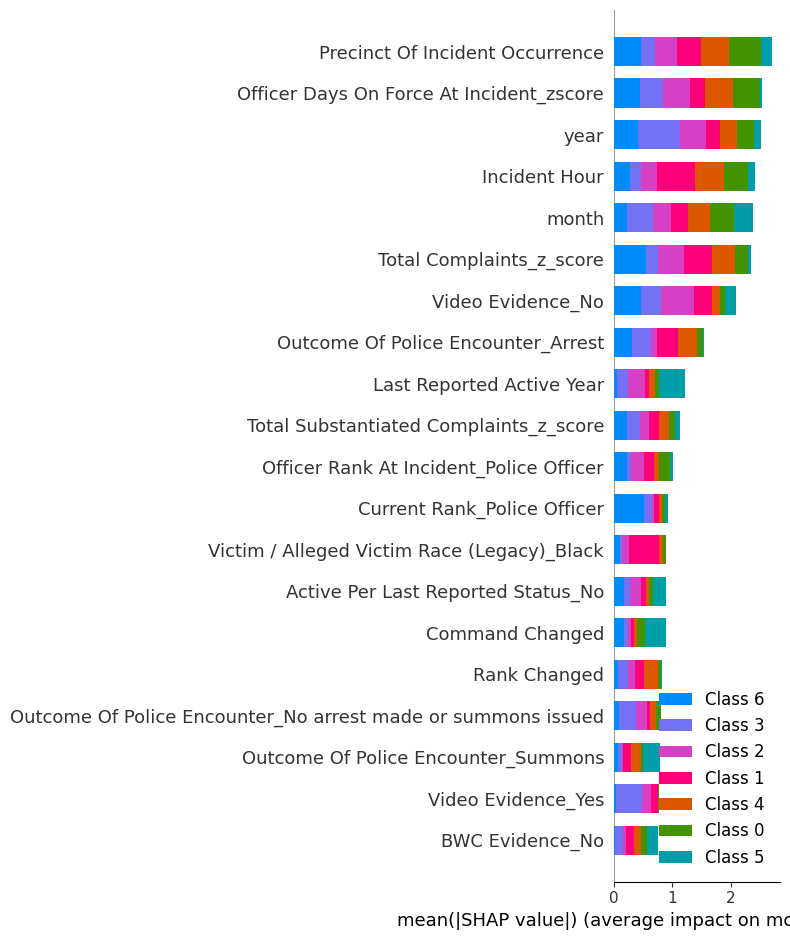

In [80]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test3, show=False)
plt.tight_layout()
plt.show()

### Predicting Penalty Count

In [81]:
penalty_df['PenaltyCount'].value_counts()

PenaltyCount
1     2095
0      371
2+      73
Name: count, dtype: int64

In [82]:
#encoding penalty type
count_encoder = LabelEncoder()
y = count_encoder.fit_transform(penalty_df['PenaltyCount'])

In [83]:
# View the class-to-integer mapping
count_map = dict(zip(count_encoder.classes_, range(len(count_encoder.classes_))))
print("Class to Integer Mapping:", dict(zip(count_encoder.classes_, range(len(count_encoder.classes_)))))

Class to Integer Mapping: {'0': 0, '1': 1, '2+': 2}


In [84]:
#training, validation, and test sets
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train4, x_valid4, y_train4, y_valid4 = train_test_split(x_train4, y_train4, test_size = 0.2, stratify = y_train4, random_state = 3)

In [85]:
#SMOTE for class imbalance
smote_penalty_c = SMOTE(random_state = 10)

#applying SMOTE to training
x_res4, y_res4 = smote_penalty_c.fit_resample(x_train4, y_train4)

In [86]:
#check class dist
print(pd.Series(y_train4).value_counts())
print(pd.Series(y_res4).value_counts())

1    1340
0     238
2      46
Name: count, dtype: int64
1    1340
0    1340
2    1340
Name: count, dtype: int64


In [87]:
def model_perf_count(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
               xticklabels=count_map, yticklabels=count_map)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

Logistic


C:\Users\helen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.22      0.49      0.30        59
           1       0.87      0.54      0.67       336
           2       0.12      0.67      0.20        12

    accuracy                           0.54       407
   macro avg       0.40      0.57      0.39       407
weighted avg       0.76      0.54      0.60       407

Balanced Accuracy: 0.5656275221953188
F1-Weighted: 0.6002855782960496
F1-Macro: 0.3901105293775451


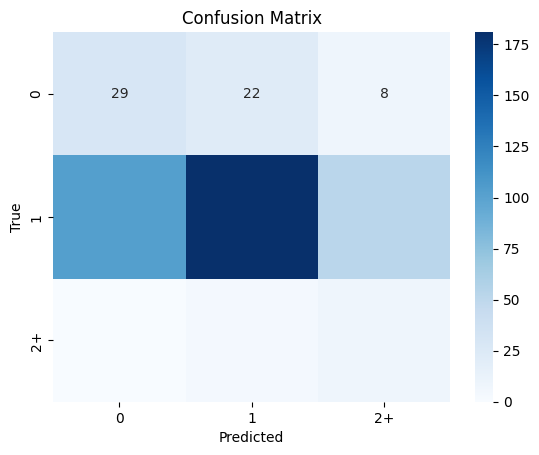

RF
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        59
           1       0.96      0.99      0.98       336
           2       1.00      0.67      0.80        12

    accuracy                           0.96       407
   macro avg       0.97      0.83      0.89       407
weighted avg       0.96      0.96      0.96       407

Balanced Accuracy: 0.8304075867635189
F1-Weighted: 0.9589778556285735
F1-Macro: 0.8891724260145314


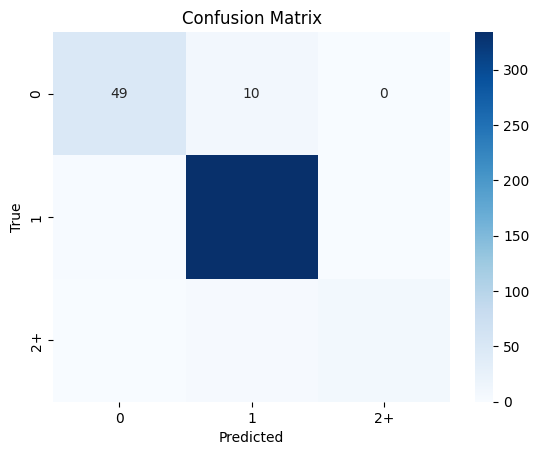

SVM
              precision    recall  f1-score   support

           0       0.11      0.36      0.17        59
           1       0.00      0.00      0.00       336
           2       0.03      0.58      0.06        12

    accuracy                           0.07       407
   macro avg       0.05      0.31      0.08       407
weighted avg       0.02      0.07      0.03       407

Balanced Accuracy: 0.31308851224105466
F1-Weighted: 0.026254131899420483
F1-Macro: 0.07660335665807334


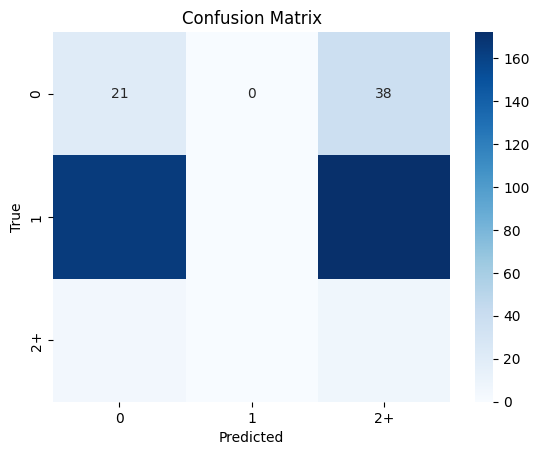

XGB
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        59
           1       0.97      1.00      0.98       336
           2       1.00      0.83      0.91        12

    accuracy                           0.97       407
   macro avg       0.98      0.90      0.94       407
weighted avg       0.97      0.97      0.97       407

Balanced Accuracy: 0.8982546408393867
F1-Weighted: 0.9722309443488372
F1-Macro: 0.9372857038055277


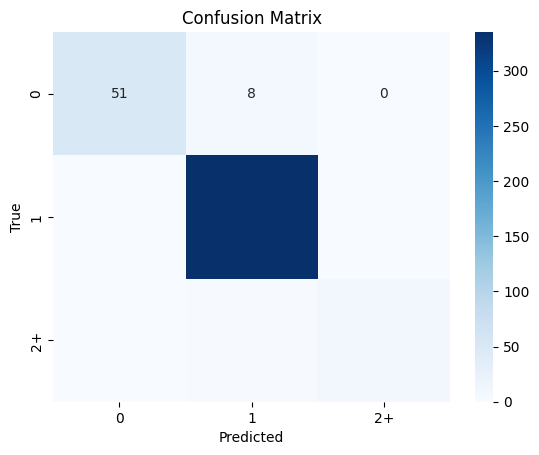

KNN
              precision    recall  f1-score   support

           0       0.55      0.95      0.70        59
           1       0.98      0.83      0.90       336
           2       0.43      0.83      0.57        12

    accuracy                           0.85       407
   macro avg       0.66      0.87      0.72       407
weighted avg       0.90      0.85      0.86       407

Balanced Accuracy: 0.869955609362389
F1-Weighted: 0.8598527046023006
F1-Macro: 0.7232171705515809


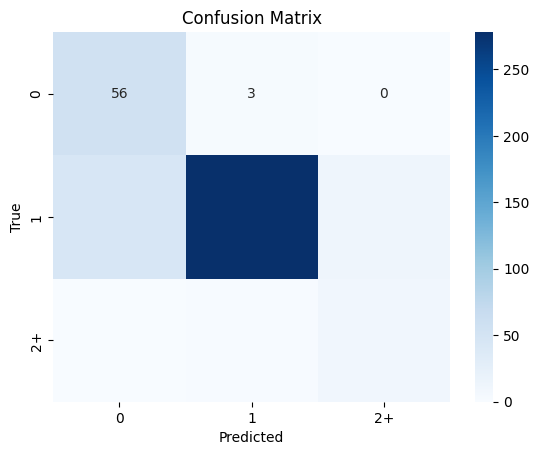

In [88]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_count(model, x_res4, y_res4, x_valid4, y_valid4)

In [89]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [90]:
top_count_models = ["RF", "XGB"]

In [91]:
score_storage = {}
param_storage = {}

In [92]:
#hyperparameter tuning
for top_mod in top_count_models:
    #fix cols
    x_res4.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res4, y_res4)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)
    
    #append
    score_storage[top_mod] = rf_gs.best_score_
    param_storage[top_mod] = rf_gs.best_params_


Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best F1 Score (Weighted) for RF: 0.9866045652001366
Best Parameters for XGB: {'subsample': 0.7, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best F1 Score (Weighted) for XGB: 0.9804550826421483


In [93]:
#Final Assessment
if score_storage["XGB"] > score_storage["RF"]:
    count_mod = XGBClassifier(**param_storage["XGB"])
else:
    count_mod = XGBClassifier(**param_storage["RF"])

In [94]:
#fit mod
count_mod.fit(x_res4, y_res4)

C:\Users\helen\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features='sqrt',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, ...)

In [95]:
#compute predicted
x_test4.columns = x_test4.columns.str.replace(r'[\[\]<>]', '', regex=True)
count_pred = count_mod.predict(x_test4)

In [96]:
#performance metrics
count_pred_conf_matrix = confusion_matrix(y_test4, count_pred)
count_pred_class_report = classification_report(y_test4, count_pred, zero_division = 0)
count_pred_fl_weighted = f1_score(y_test4, count_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.98      0.84      0.91        74
           1       0.97      1.00      0.98       419
           2       1.00      0.87      0.93        15

    accuracy                           0.97       508
   macro avg       0.98      0.90      0.94       508
weighted avg       0.97      0.97      0.97       508

F1-Weighted: 0.9695300092739849


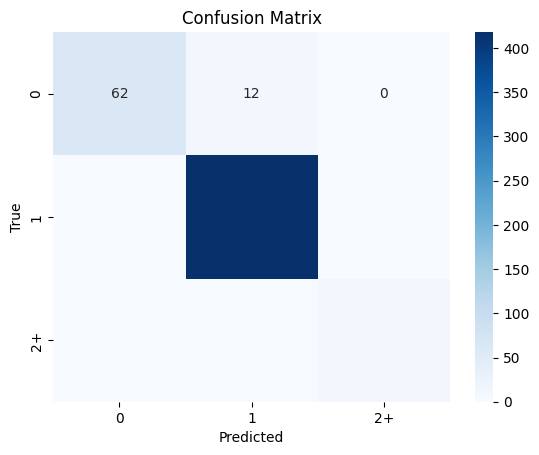

In [97]:
#printing report
print(count_pred_class_report)
print(f'F1-Weighted: {count_pred_fl_weighted}')

#confusion matrix plot
sns.heatmap(count_pred_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues,
           xticklabels=count_map, yticklabels=count_map
)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [98]:
pd.DataFrame({
    'Feature': x_res4.columns,
    'Importance': count_mod.feature_importances_
}).sort_values(by = 'Importance', ascending = False).head(20)

,Feature,Importance
62,Outcome Of Police Encounter_Juvenile Report,0.063072
23,FADO Type_Abuse of Authority,0.052200
16,Officer Rank At Incident_Deputy Inspector,0.047119
7,Command Changed,0.040297
20,Officer Rank At Incident_Police Officer,0.037852
11,news_hits,0.034983
71,Officer Race_American Indian,0.033068
54,Reason for Police Contact_Aid,0.028076
26,FADO Type_Offensive Language,0.026683
13,recent_prev_subs,0.026449


In [99]:
#Count Mod
explainer = shap.Explainer(count_mod, x_train4)
shap_values = explainer(x_test4)

 96%|=================== | 1464/1524 [00:20<00:00]       

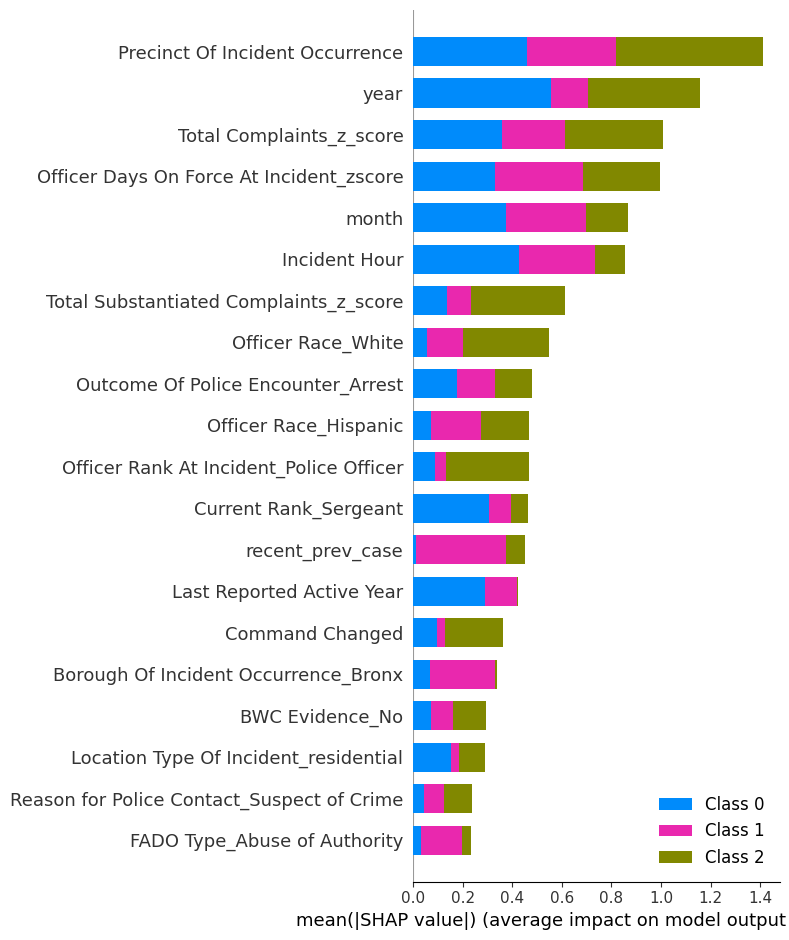

In [100]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
shap.summary_plot(shap_values, x_test4, show=False)
plt.tight_layout()
plt.show()